# Set up

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4090


In [62]:
import pandas as pd
import utility_functions as utils

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
#%% import

import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import utility_functions as utils
import GLM
from DataLoader import Allen_dataset

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

# Decoder (numpy version; legacy)

When the encoder and the simulus effects are fixed, this decoder would give the posterior of graphical latents very quickly (optimized using Newton's method). 

In [3]:
def get_K(sigma2=1.0, L=100.0, nt=500):
    """
    Get the covariance matrix K for GPFA.

    Parameters:
    - sigma2 (float): The variance of the Gaussian kernel.
    - L (float): The length scale of the Gaussian kernel.
    - n (int): The number of time bins.

    Returns:
    - K (ndarray): The covariance matrix. Shape: (n, n).
    """
    x = np.linspace(0, nt-1, nt)
    diff = np.subtract.outer(x, x)
    K = sigma2 * np.exp(-diff**2 / L**2)
    return K


In [38]:
def make_4d_diagonal(mat):
    """
    Take a matrix of shape (n, m, l) and return a 3D array of shape (n, m, l, l) where
    the original matrix is repeated along the last axis.
    """
    # Initialize an empty 3D array with the required shape
    mat_diag = np.zeros((mat.shape[0], mat.shape[1], mat.shape[2], mat.shape[2]))

    # Use advanced indexing to fill in the diagonals
    i = np.arange(mat.shape[2])
    mat_diag[:, :, i, i] = mat

    return mat_diag

# mat = np.random.rand(2, 3, 4)  # Example input matrix of shape (2, 3, 4)
# mat_4d_diag = make_4d_diagonal(mat)

# print(mat[0,0,:])
# mat_4d_diag[0,0,:,:]

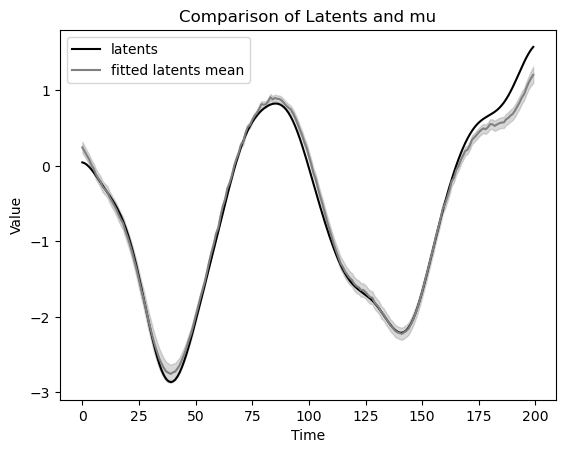

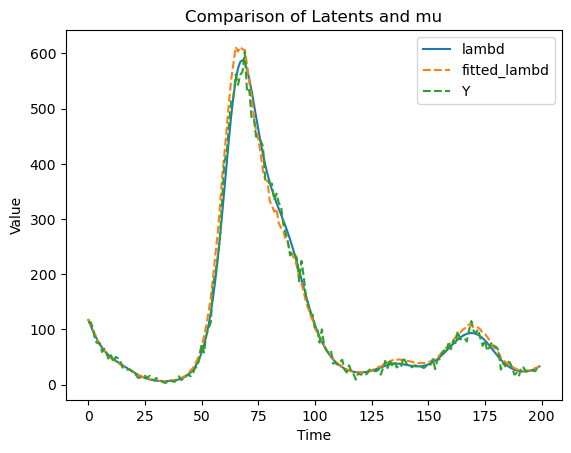

In [40]:
import numpy as np
def gpfa_poisson_fix_weights(Y, 
                             weights,
                             K,
                             bias=None, 
                             max_iter=10, 
                             tol=1e-2, 
                             verbose=False):
    """
    Perform Gaussian Process Factor Analysis (GPFA) with fixed weights for Poisson data.

    Parameters:
    - Y (ndarray): The observed spike counts. Shape: (ntrial, nneuron, nt).
    - weights (ndarray): The fixed weights matrix. Shape: (nneuron, nlatent).

    Returns:
    - mu (ndarray): The estimated latent variables. Shape: (ntrial, nlatent, nt).
    """
    
    # Get dimensions
    if Y.ndim == 2:
        Y = Y[np.newaxis, :, :]
    ntrial, nneuron, nt = Y.shape
    nlatent = weights.shape[1]

    # Initialize latents with all zeros
    # mu = np.zeros((ntrial, nlatent, nt))
    # mu = np.ones((ntrial, nlatent, nt))
    mu = np.random.rand(ntrial, nlatent, nt)
    
    # K = get_K(nt=nt, L=50)
    inv_K = np.linalg.inv(K+1e-3*np.eye(nt))
    if bias is None:
        bias = 4
    loss_old = -np.inf

    for i in range(max_iter):
        
        log_lambd = weights@mu + bias
        lambd = np.exp(log_lambd)
        loss = np.sum(Y*log_lambd - lambd)
        if verbose:
            print(f'Loss changed  {loss-loss_old}')
        if i>=10 and loss-loss_old < 1e-3:
            print(f'Converged at iteration {i} with loss {loss}')
            break
        grad = weights.T@(Y-lambd) - mu@inv_K
        hessian = -inv_K[np.newaxis, np.newaxis, :, :] - make_4d_diagonal(((weights**2).T)@lambd)
        # eigenvalues = np.linalg.eigvalsh(hessian)
        # assert np.all(eigenvalues <= 0.1)

        # mu_new = mu + 1e-3*grad
        mu_new = mu - 1e-1*np.linalg.solve(hessian, grad)
        
        loss_old = loss
        # Check convergence
        if np.linalg.norm(mu-mu_new) < tol:
            print(f'Converged at iteration {i} with loss {loss}')
            break
        mu = mu_new
        
    return mu_new, np.linalg.inv(hessian), lambd

# Parameters for data generation
ntrial = 100  # Number of trials
nt = 200    # Number of time bins
nneuron = 10 # Number of neurons
nlatent = 4 # Number of latent variables

# Generate covariance matrix K for the latent variables
K = get_K(nt=nt, L=20)

# Generate latent variables from a multivariate normal distribution
np.random.seed(0)
latents = np.random.multivariate_normal(np.zeros(nt), K, (ntrial, nlatent))
# latents = np.swapaxes(latents, 1, 2)

# Known weights matrix
np.random.seed(0)
weights = np.abs(np.random.rand(nneuron, nlatent))

# Generate observed spike counts Y
# Calculate the mean of the Poisson distribution
lambd = np.exp(weights@latents+4)
# Sample Y from Poisson distribution
Y = np.random.poisson(lambd)

# Now Y, weights, and K can be used to test the gpfa_poisson_fix_weights function
mu, cov, fitted_lambd = gpfa_poisson_fix_weights(Y, weights, K, max_iter=100, verbose=False)


plt.figure()
plt.plot(latents[0, 0, :], label='latents', color='k')
std = np.sqrt(np.diagonal(-cov, axis1=-2, axis2=-1))
lower_bound = mu - 1.96 * std
upper_bound = mu + 1.96 * std
plt.plot(mu[0, 0, :], label='fitted latents mean', color='grey')
plt.fill_between(range(nt), lower_bound[0, 0, :], upper_bound[0, 0, :], alpha=0.3, color='grey')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

plt.figure()
plt.plot(lambd[0, 0, :], label='lambd')
plt.plot(fitted_lambd[0, 0, :], '--', label='fitted_lambd')
plt.plot(Y[0, 0, :]+0.1, '--', label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

In [10]:
def incomplete_cholesky(K, eta):
    
    """
    Incomplete Cholesky factorization according to the algorithm provided.
    
    Args:
    K (numpy.ndarray): An N x N semidefinite positive matrix.
    eta (float): Precision parameter.
    
    Returns:
    P (numpy.ndarray): Permutation matrix.
    G (numpy.ndarray): Lower triangular matrix.
    M (int): The rank of G.
    """
    N = K.shape[0]
    P = np.eye(N)  # Initialize permutation matrix as the identity matrix
    K_prime = K.copy()
    G = np.zeros_like(K_prime)  # Initialize G with zeros
    np.fill_diagonal(G, K_prime.diagonal())  # Set diagonal elements of G
    
    i = 0
    while np.sum(np.diag(G)[i:]**2) > eta:
        # Find best new element
        j_star = np.argmax(K_prime.diagonal()[i:])
        j_star += i  # Adjust index since argmax is relative to subarray starting at i

        # Update permutation P
        P[i, i] = 0
        P[j_star, j_star] = 0
        P[i, j_star] = 1
        P[j_star, i] = 1
        K_prime[[i, j_star], :] = K_prime[[j_star, i], :]  # Swap rows
        K_prime[:, [i, j_star]] = K_prime[:, [j_star, i]]  # Swap columns
        
        # Update G due to new permutation
        G[[i,j_star], :i+1] = G[[j_star,i], :i+1]
        
        # Set Gii
        G[i, i] = np.sqrt(K_prime[i, i])
        
        # Calculate i-th column of G
        G[i+1:, i] = (K_prime[i+1:, i] - (G[i+1:, :i]@(G[i, :i][:,np.newaxis])).flatten()) / G[i, i]
        
        # Update only diagonal elements
        for j in range(i+1, N):
            G[j, j] = K_prime[j, j] - np.sum(G[j, :i+1]**2)
        
        i += 1  # Increment index

        # if i>=4:
        #     break
    r = i - 1  # Rank of G
    return P, G[:,:i-1], r


K = get_K(nt=5, L=3)
eta = 1e-1  # Precision parameter
P, G, r = incomplete_cholesky(K, eta)
print("Permutation matrix P:", P)
print("Lower triangular matrix G:", G)
print(K)
print(G@G.T)


Permutation matrix P: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Lower triangular matrix G: [[1.         0.         0.         0.        ]
 [0.89483932 1.         0.         0.        ]
 [0.64118039 0.3210859  1.         0.        ]
 [0.36787944 0.3119874  0.55878748 1.        ]
 [0.16901332 0.21663968 0.46325242 0.50621429]]
[[1.         0.89483932 0.64118039 0.36787944 0.16901332]
 [0.89483932 1.         0.89483932 0.64118039 0.36787944]
 [0.64118039 0.89483932 1.         0.89483932 0.64118039]
 [0.36787944 0.64118039 0.89483932 1.         0.89483932]
 [0.16901332 0.36787944 0.64118039 0.89483932 1.        ]]
[[1.         0.89483932 0.64118039 0.36787944 0.16901332]
 [0.89483932 1.8007374  0.89483932 0.64118039 0.36787944]
 [0.64118039 0.89483932 1.51420844 0.89483932 0.64118039]
 [0.36787944 0.64118039 0.89483932 1.54491487 0.89483932]
 [0.16901332 0.36787944 0.64118039 0.89483932 0.54635396]]


# Decoder (pytorch version)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_K(sigma2=1.0, L=100.0, nt=500, use_torch=False, device='cpu'):
    """
    Get the covariance matrix K for GPFA.

    Parameters:
    - sigma2 (float): The variance of the Gaussian kernel.
    - L (float): The length scale of the Gaussian kernel.
    - nt (int): The number of time bins.
    - device (str or torch.device): The device to create the tensor on.

    Returns:
    - K (Tensor): The covariance matrix. Shape: (nt, nt).
    """
    x = np.linspace(0, nt-1, nt)
    diff = np.subtract.outer(x, x)
    K = sigma2 * np.exp(-diff**2 / L**2)
    # Convert to a PyTorch tensor and then move to the specified device
    if use_torch:
        return torch.from_numpy(K).to(device)
    else:
        return K


In [5]:
def make_4d_diagonal(mat):
    """
    Take a matrix of shape (n, m, l) and return a 3D array of shape (n, m, l, l) where
    the original matrix is repeated along the last axis.
    """
    # Initialize an empty 3D tensor with the required shape
    mat_diag = torch.zeros((mat.shape[0], mat.shape[1], mat.shape[2], mat.shape[2]), device=mat.device)

    # Use advanced indexing to fill in the diagonals
    i = torch.arange(mat.shape[2], device=mat.device)
    mat_diag[:, :, i, i] = mat

    return mat_diag

# mat = torch.rand(2, 3, 4)  # Example input matrix of shape (2, 3, 4)
# mat_4d_diag = make_4d_diagonal(mat)

# print(mat[0,0,:])
# mat_4d_diag[0,0,:,:]

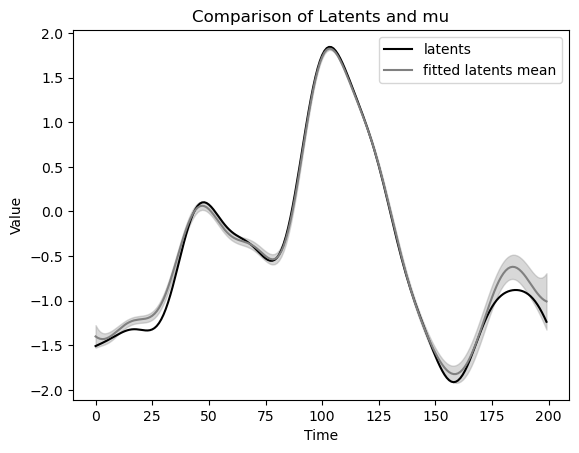

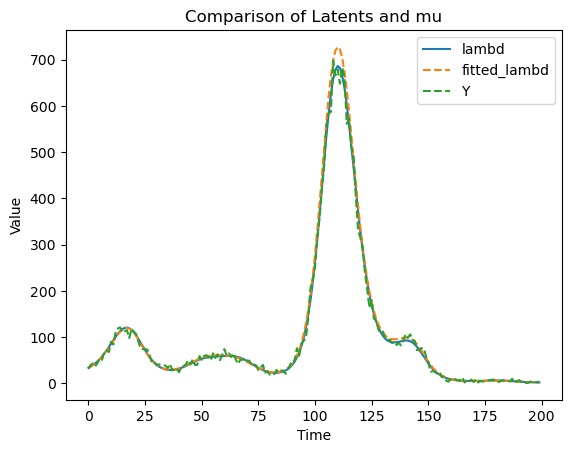

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def gpfa_poisson_fix_weights(Y, weights, K, bias=None, max_iter=10, tol=1e-2, verbose=False):
    """
    Perform Gaussian Process Factor Analysis (GPFA) with fixed weights for Poisson data using PyTorch.

    Parameters:
    - Y: Tensor of shape (ntrial, nneuron, nt) representing the observed spike counts.
    - weights: Tensor of shape (nneuron, nlatent) representing the weights connecting neurons to latent variables.
    - K: Tensor of shape (nt, nt) representing the covariance matrix of the latent variables.
    - bias: Optional scalar Tensor representing the bias term. If not provided, a default value of 4.0 is used.
    - max_iter: Maximum number of iterations for the optimization algorithm. Default is 10.
    - tol: Tolerance for convergence. Default is 1e-2.
    - verbose: Boolean flag indicating whether to print progress information during optimization. Default is False.

    Returns:
    - mu: Tensor of shape (ntrial, nlatent, nt) representing the estimated latent variables.
    - inv_K: Tensor of shape (nt, nt) representing the inverse of the covariance matrix of the latent variables.
    - lambd: Tensor of shape (ntrial, nneuron, nt) representing the estimated spike rates.

    """
    device = Y.device
    ntrial, nneuron, nt = Y.shape
    nlatent = weights.shape[1]

    # Expand Y dimensions if needed
    if Y.ndimension() == 2:
        Y = Y.unsqueeze(0)

    # Initialize latents
    mu = torch.rand(ntrial, nlatent, nt, device=device)
    
    # Inverse of K with regularization
    inv_K = torch.linalg.inv(K + 1e-5 * torch.eye(nt, device=device))
    if bias is None:
        bias = torch.tensor(4.0, device=device)
    else:
        bias = torch.tensor(bias, device=device)
    loss_old = float('-inf')

    for i in range(max_iter):
        log_lambd = torch.matmul(weights, mu) + bias
        lambd = torch.exp(log_lambd)
        loss = torch.sum(Y * log_lambd - lambd)
        if verbose:
            print(f'Iteration {i}: Loss change {loss.item() - loss_old}')
        if loss.item() - loss_old < tol and i >= 1:
            if verbose:
                print(f'Converged at iteration {i} with loss {loss.item()}')
            break

        grad = torch.matmul(weights.t(), (Y - lambd)) - torch.matmul(mu, inv_K)
        # hessian = -inv_K.unsqueeze(0).unsqueeze(0).repeat(ntrial, nlatent, 1, 1) - torch.matmul(weights.t().unsqueeze(-1) * weights.t().unsqueeze(-2), lambd_diag)
        hessian = -inv_K.unsqueeze(0).unsqueeze(0) - make_4d_diagonal(((weights**2).T)@lambd)
        
        # Solving the linear system for each trial and latent dimension
        mu_update = torch.linalg.solve(hessian, grad.unsqueeze(-1)).squeeze(-1)

        mu_new = mu - 0.2e-1 * mu_update

        loss_old = loss.item()

        # Check convergence
        if torch.norm(mu - mu_new) < tol:
            if verbose:
                print(f'Converged at iteration {i} with loss {loss.item()}')
            break
        mu = mu_new

    return mu, hessian, lambd
# Parameters for data generation
ntrial = 100  # Number of trials
nt = 200    # Number of time bins
nneuron = 10 # Number of neurons
nlatent = 4 # Number of latent variables

# Generate covariance matrix K for the latent variables
K = get_K(nt=nt, L=20)

# Generate latent variables from a multivariate normal distribution
np.random.seed(5)
latents = np.random.multivariate_normal(np.zeros(nt), K, (ntrial, nlatent))
# latents = np.swapaxes(latents, 1, 2)

# Known weights matrix
np.random.seed(0)
weights = np.abs(np.random.rand(nneuron, nlatent))

# Generate observed spike counts Y
# Calculate the mean of the Poisson distribution
lambd = np.exp(weights@latents+4)
# Sample Y from Poisson distribution
Y = np.random.poisson(lambd)

# Call the function with tensors
mu, hessian, fitted_lambd = gpfa_poisson_fix_weights(torch.from_numpy(Y).float().to(device), 
                                                 torch.from_numpy(weights).float().to(device), 
                                                 torch.from_numpy(K).float().to(device), 
                                                 max_iter=1000, 
                                                 verbose=False)

# Conversion for plotting (PyTorch tensor to NumPy array)
mu = mu.cpu().numpy()
hessian = hessian.cpu().numpy()
fitted_lambd = fitted_lambd.cpu().numpy()

# Plotting code remains
plt.figure()
plt.plot(latents[0, 0, :], label='latents', color='k')
std = np.sqrt(np.diagonal(-np.linalg.inv(hessian), axis1=-2, axis2=-1))
lower_bound = mu - 1.96 * std
upper_bound = mu + 1.96 * std
plt.plot(mu[0, 0, :], label='fitted latents mean', color='grey')
plt.fill_between(range(nt), lower_bound[0, 0, :], upper_bound[0, 0, :], alpha=0.3, color='grey')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

plt.figure()
plt.plot(lambd[0, 0, :], label='lambd')
plt.plot(fitted_lambd[0, 0, :], '--', label='fitted_lambd')
plt.plot(Y[0, 0, :]+0.1, '--', label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

# Encoder

When at a point in the parameter space of the encoder, the decoder first generate the variational posterior, then taking the posterior as fixed values, perform gradient descent with regard to the encoder parameters, taking ELBO as the objective function. 

In the below code, I want to make sure when the latent is correct, if the weight converge to ground truth. 

```
latent (ntrial, nlatent, nt) 
--W--> 
communication subspace (ntrial, narea, narea, ns, nt)

coefficients of basis (:, narea, narea, ns, nb, :)
```

## Numpy version of "conv" (legacy)

In [20]:
def conv(raw_input, kernel, npadding=None, enforce_causality=True):
    ntrial, nneuroni, nt = raw_input.shape
    if enforce_causality:
        kernel = np.concatenate((np.zeros((kernel.shape[0], 1, kernel.shape[2])), kernel), axis=1)
    ntau = kernel.shape[1]
    assert kernel.shape[0]==nneuroni, 'The number of neurons in the kernel should be the same as the input'
    nneuronj = kernel.shape[2]
    
    nn = nt + ntau - 1
    G = ifft( fft(raw_input, nn, axis=2)[:,:,:,np.newaxis] * fft(kernel, nn, axis=1)[np.newaxis, :, :, :] , axis=2)
    G = G[:,:,:nt,:].real
    G[np.abs(G)<1e-10] = 0
    if npadding is not None:
        G = G[npadding:,:]
    return G

In [19]:
# Sample spike train data
raw_input = np.array([[1, 0, 0, 0, 0,0,0,],
                     [0, 1, 0, 0, 0,0,0,],
                     [0, 0, 1, 0, 0,0,0,]])
raw_input = raw_input[np.newaxis,:,:]

# Sample kernel
kernel = np.zeros((3,5,2))
kernel[0,:,0] = np.array([0.5, 0.3, 0.1, 0, 0])
kernel[2,:,1] = np.array([0.6, 0.4, 0.2, 0, 0])
# kernel = np.array([[0.5, 0.3, 0.1], [3, 2, 1]]).T

# Call the conv function
# X = conv_multi_trial(raw_input, kernel)
X = conv(raw_input, kernel)

# Print the result
print(X.shape)
print(X[0,:,:,:])
print(X[0,0,:,0])
print(X[0,2,:,1])


(1, 3, 7, 2)
[[[0.  0. ]
  [0.5 0. ]
  [0.3 0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0.6]
  [0.  0.4]
  [0.  0.2]
  [0.  0. ]]]
[0.  0.5 0.3 0.1 0.  0.  0. ]
[0.  0.  0.  0.6 0.4 0.2 0. ]


## Pytorch version of "conv"

In [118]:
def conv(raw_input, kernel, npadding=None, enforce_causality=True):
    """
    Applies convolution operation on the input tensor using the given kernel.

    Args:
        raw_input (torch.Tensor): Input tensor of shape (ntrial, nneuroni, nt).
        kernel (torch.Tensor): Convolution kernel of shape (nneuroni, ntau, nneuronj).
        npadding (int, optional): Number of padding time to remove from the output. Defaults to None.
        enforce_causality (bool, optional): Whether to enforce causality by zero-padding the kernel. Defaults to True.

    Returns:
        torch.Tensor: Convolved tensor of shape (ntrial, nneuroni, nt + ntau - 1).

    Raises:
        AssertionError: If the number of neurons in the kernel is not the same as the input.

    """
    
    device = raw_input.device
    ntrial, nneuroni, nt = raw_input.shape
    if enforce_causality:
        zero_pad = torch.zeros((kernel.shape[0], 1, kernel.shape[2]), dtype=torch.float32, device=device)
        kernel = torch.cat((zero_pad, kernel), dim=1)
    ntau = kernel.shape[1]
    assert kernel.shape[0] == nneuroni, 'The number of neurons in the kernel should be the same as the input'
    nneuronj = kernel.shape[2]
    
    nn = nt + ntau - 1
    G = torch.fft.ifft(torch.fft.fft(raw_input, n=nn, dim=2).unsqueeze(3) * torch.fft.fft(kernel, n=nn, dim=1).unsqueeze(0), dim=2)
    G = G.real
    G[torch.abs(G) < 1e-5] = 0
    G = G[:,:,:nt,:]
    if npadding is not None:
        G = G[:,:,npadding:,:]
    return G.transpose(-1,-2)



In [120]:
# Sample spike train data
raw_input = torch.tensor([[1, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0]], dtype=torch.float32, device='cpu')
raw_input = raw_input.unsqueeze(0)

# Sample kernel
kernel = torch.zeros((3, 5, 2), dtype=torch.float32, device='cpu')
kernel[0, :, 0] = torch.tensor([0.5, 0.3, 0.1, 0, 0])
kernel[2, :, 1] = torch.tensor([0.6, 0.4, 0.2, 0, 0])

# Call the conv function
X = conv(raw_input, kernel)

# Print the result
print(X.shape)
print(X[0, :, :, :])
print(X[0, 0, 0,:])
print(X[0, 2, 1,:])


torch.Size([1, 3, 2, 7])
tensor([[[0.0000, 0.5000, 0.3000, 0.1000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.6000, 0.4000, 0.2000, 0.0000]]])
tensor([0.0000, 0.5000, 0.3000, 0.1000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 0.6000, 0.4000, 0.2000, 0.0000])


## Get baseline and coupling from real data

In [11]:
# Load selected group_id
import pickle
with open('group_id_all_a_c/membership.pickle', 'rb') as handle:
    membership = pickle.load(handle)
with open('group_id_all_a_c/condition_ids.pickle', 'rb') as handle:
    condition_ids = pickle.load(handle)

probe_list = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

# Load data
start_time = 0.0
end_time = 0.50
padding = 0.3
V1 = Allen_dataset(fps=1000,
                   start_time=start_time, 
                   end_time=end_time,
                   padding=padding,
#                    orientation=[0],
                   session_id=757216464,
                   selected_probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'],
#                    temporal_frequency=[1,2,4],
                   stimulus_condition_id=[275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270],
#                    stimulus_condition_id=[246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 
#                                           262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277,
#                                           278, 279, 280, 281, 282, 283, 284, 285, 286, 270],
                   stimulus_name='drifting_gratings')

# V1.get_lfp()
# V1.remove_padding(padding)
V1.get_trial_metric_per_unit_per_trial()
# V1.get_trial_metric_per_unit_per_trial(metric_type='spike_times')
V1.get_running(method="mine")

/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/stimulus_table/naming_utilities.py:154: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_rows = table[stim_colname].str.contains(movie_re, na=False)
/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1315: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [12]:
# The following hyperparameters turned out to be the best
num_f_refractory = 4
max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':26, 'num':3, 'nonlinear':0.9}
coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 20
penalty = 5e-1

################ No need to change below
probe_list = V1.selected_probes

running_model_list = []
stationary_model_list = []

for i, target_probe in tqdm(enumerate(probe_list)):
    select_trials = V1.running_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j], apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    running_model_list.append(model)
    
    select_trials = V1.stationary_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j],apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    # model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    model.fit(target_probe, verbose=False, penalty=penalty)
    stationary_model_list.append(model)


6it [00:29,  4.99s/it]


## Generate simulated spike trains from GLM neurons

In [13]:
def get_K(sigma2=1.0, L=100.0, nt=500):
    """
    Get the covariance matrix K for GPFA.

    Parameters:
    - sigma2 (float): The variance of the Gaussian kernel.
    - L (float): The length scale of the Gaussian kernel.
    - n (int): The number of time bins.

    Returns:
    - K (ndarray): The covariance matrix. Shape: (n, n).
    """
    x = np.linspace(0, nt-1, nt)
    diff = np.subtract.outer(x, x)
    K = sigma2 * np.exp(-diff**2 / L**2)
    return K


In [610]:
### Generate data
torch.manual_seed(0)
np.random.seed(0)

MAX_FIRING_RATE = 10
model_list = stationary_model_list
ntrial = 1000

narea = 3
nneuron_area = 1
npadding = 100
nneuron = narea*nneuron_area

max_histories = model_list[0].filters[1].shape[0]
nt = model_list[0].nt + npadding
coupling_mat = np.zeros((max_histories, nneuron, nneuron))
baseline_mat = np.ones((nt, nneuron))*np.log(0.05)
spikes = np.zeros((ntrial, nneuron, nt))

coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
basis_coupling = basis_coupling[:,:1]

### Generate coupling matrix
for jarea in range(narea):
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area] = np.log(0.05)
    for iarea in range(narea):
        # if jarea == iarea+1 and jarea in [1]:
        if iarea == 0 and jarea != iarea:
            coupling_mat[:, iarea*nneuron_area:(iarea+1)*nneuron_area, jarea*nneuron_area:(jarea+1)*nneuron_area] \
                = np.flip(1*basis_coupling[:,0])[:, np.newaxis, np.newaxis]

### Generate time-varying coupling strength coefficients
nlatent = 1
max_project_w = 0.5
project_w = max_project_w*(np.random.rand(narea, narea, nlatent)*2-1)
K = get_K(nt=nt, L=500)
latents = np.random.multivariate_normal(np.zeros(nt), K, (nlatent, ntrial))
time_varying_coef = np.einsum('...i, ijk -> ...jk', project_w, latents) + 1


### Rescale the time varying coefficients to have mean value of 1
### Rescale the coupling matrix to have maximum absolute value of 1
# rescale = 1/abs(coupling_mat).max()
# time_varying_coef *= 1/rescale
# latents *= 1/rescale
# coupling_mat *= rescale
# time_varying_coef: narea x narea x ntrial x nt

### Generate spikes
for itrial in range(ntrial):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,np.newaxis])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:,0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        temp_log_firing_rate = (coupling_mat[-nhistories:, :, :] \
            * np.kron(time_varying_coef[:,:,itrial,t][np.newaxis,:,:], np.ones((nneuron_area, nneuron_area))) \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        log_firing_rate[t,:,0] += temp_log_firing_rate
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[itrial, :, :] = spikes_single_trial.T
    
print(spikes.max())

44.0


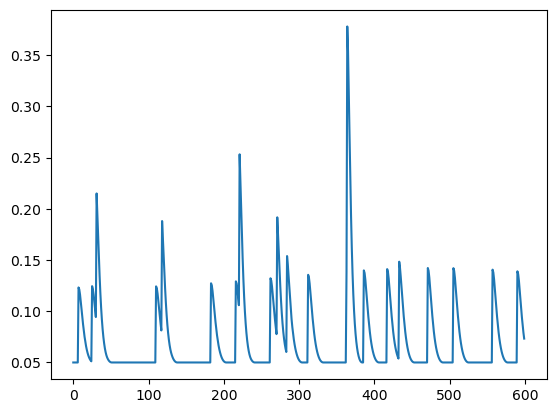

In [611]:
plt.plot(np.exp(log_firing_rate[:,2]))

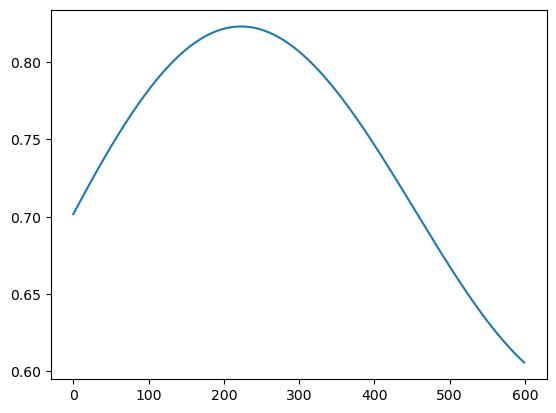

In [603]:
plt.plot(time_varying_coef[0,1,:1,:].T)

# Build the model

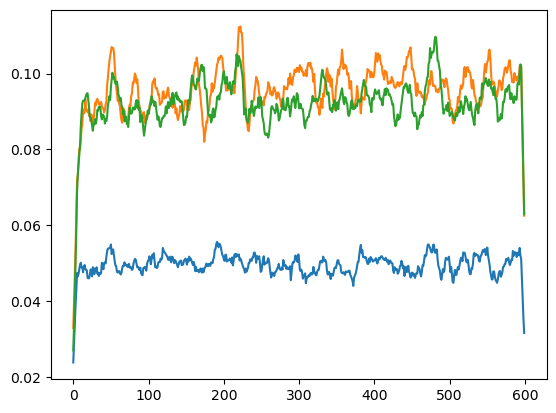

In [613]:
spikes = [spikes[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

window_size = 10

for i in range(narea):
    smoothed_spikes = np.convolve(spikes[i].mean(axis=(0,1)), np.ones(window_size)/window_size, mode='same')
    plt.plot(smoothed_spikes)

In [630]:
# Input needed: spikes, narea, nneuron_area

# Define the linear model
class FC_GPFC(nn.Module):
    def __init__(self, spikes, latents=None, fix_latent=False, nlatent=None, npadding=None):
            """
            Initialize the FC_GPFC class.

            Parameters:
            spikes (list): A list of spike data for each population.
            latents (ndarray, optional): Latent variables. Defaults to None.
            fix_latent (bool, optional): Flag indicating whether to fix the latent variables. Defaults to False.
            nlatent (int, optional): Number of latent variables. Defaults to None.
            npadding (int, optional): Number of padding time points. Defaults to None.
            """
            
            super(FC_GPFC, self).__init__()
            self.spikes = [torch.tensor(spike) for spike in spikes]
            self.npop = len(self.spikes)
            self.ntrial, _, self.nt = self.spikes[0].shape
            self.npadding = npadding
            self.nt -= self.npadding
            self.nneuron = [spike.shape[1] for spike in spikes]
            
            if latents is not None:
                self.nlatent = latents.shape[0]
                self.latents = torch.tensor(latents, dtype=torch.float32)
            else:
                raise ValueError("Unfinished")
            
            self.latents_readout = nn.Parameter(0.1 * (torch.randn(self.npop, self.npop, self.nlatent) * 2 - 1))
            self.time_varying_coef_offset = nn.Parameter(0.1 * (torch.randn(self.npop, self.npop, 1, 1) * 2 - 1))
            # self.latents_readout = torch.tensor(project_w)
            # self.time_varying_coef_offset = 1
            
            coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
            basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
            basis_coupling = basis_coupling[:,:1]
            self.basis_coupling = torch.tensor(basis_coupling, dtype=torch.float32)
            
            self.beta_coupling = nn.ModuleList([
                nn.ParameterList([
                    nn.Parameter(0.01*torch.randn(basis_coupling.shape[1], self.nneuron[ipop], self.nneuron[jpop]))
                    for jpop in range(self.npop)])
                for ipop in range(self.npop)])
            
            self.beta_inhomo = nn.ParameterList([
                nn.Parameter(torch.unsqueeze(torch.unsqueeze(self.spikes[jpop].mean(axis=(0,2)), 0), 2))
                for jpop in range(self.npop)])
        
    def forward(self):
        # basis_coupling, beta_coupling -> coupling_filters
        self.coupling_filters = [[torch.einsum('ij,jkl->ikl', self.basis_coupling, self.beta_coupling[ipop][jpop]).transpose(0,1)
            for jpop in range(self.npop)] for ipop in range(self.npop)]
        # Generate time-varying coupling strength coefficients
        self.time_varying_coef = torch.einsum('ijk,klm -> ijlm', self.latents_readout, self.latents) + self.time_varying_coef_offset
        
        # coupling_filters, spike trains, time_varying_coef (total coupling effects) -> log_firing_rate
        self.log_firing_rate = [torch.zeros(self.ntrial, self.nneuron[jpop], self.nt) for jpop in range(self.npop)]
        for jpop in range(self.npop):
            for ipop in range(self.npop):
                if ipop == jpop:
                    continue
                self.log_firing_rate[jpop] += conv(self.spikes[ipop], self.coupling_filters[ipop][jpop], npadding=self.npadding).sum(axis=1) \
                    *torch.unsqueeze(self.time_varying_coef[ipop, jpop, :, :], 1)
        
        # inhomo -> log_firing_rate
        for jpop in range(self.npop):
            self.log_firing_rate[jpop] += self.beta_inhomo[jpop]
            # self.log_firing_rate[jpop] += np.log(0.05)
        
        return self.log_firing_rate

# Instantiate the model
npadding = 100
model = FC_GPFC(spikes, latents=latents[:,:,npadding:], npadding=npadding)

# Define loss function and optimizer
criterion = nn.PoissonNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
num_epochs = 2000
best_loss = float('inf')
no_improvement_count = 0
tol = 1e-4

for epoch in range(num_epochs):
    # Forward pass
    outputs = model()
    loss = 0
    for i, output in enumerate(outputs):
        loss += criterion(outputs[i], model.spikes[i][:,:,npadding:])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Check if loss has improved
    if loss < best_loss-tol:
        best_loss = min(loss, best_loss)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= 3:
            print("No improvement for three epochs. Stopping training.")
            break


Epoch [0/2000], Loss: 3.2213
Epoch [100/2000], Loss: 1.3001
Epoch [200/2000], Loss: 1.1080
Epoch [300/2000], Loss: 0.9941
Epoch [400/2000], Loss: 0.9226
Epoch [500/2000], Loss: 0.8755
Epoch [600/2000], Loss: 0.8380
Epoch [700/2000], Loss: 0.8140
Epoch [800/2000], Loss: 0.7996
Epoch [900/2000], Loss: 0.7907
Epoch [1000/2000], Loss: 0.7852
No improvement for three epochs. Stopping training.


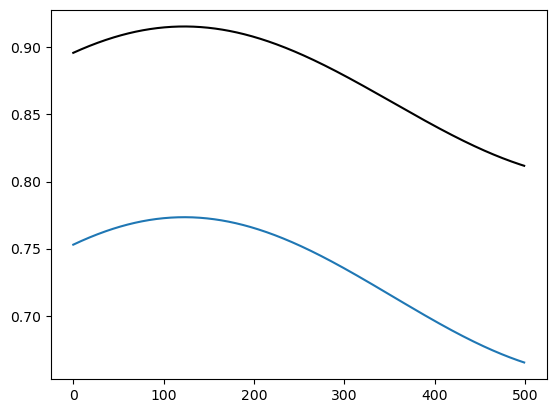

In [644]:
plt.plot(time_varying_coef[0,2,:1,npadding:].T, 'k')
plt.plot(model.time_varying_coef[0,2,:1,:].detach().numpy().T*model.beta_coupling[0][2].detach().numpy()[0,0,0])


In [584]:
model.latents_readout, model.latents_offset, model.beta_coupling[0][1], torch.exp(model.beta_inhomo[0]),torch.exp(model.beta_inhomo[1]), torch.exp(model.beta_inhomo[2])

(tensor([[[ 0.0488],
          [ 0.2152],
          [ 0.1028]],
 
         [[ 0.0449],
          [-0.0763],
          [ 0.1459]],
 
         [[-0.0624],
          [ 0.3918],
          [ 0.4637]]], dtype=torch.float64),
 1,
 Parameter containing:
 tensor([[[ 0.8453]],
 
         [[ 0.1391]],
 
         [[-0.1614]]], requires_grad=True),
 tensor([[[0.1216]]], dtype=torch.float64, grad_fn=<ExpBackward0>),
 tensor([[[0.0674]]], dtype=torch.float64, grad_fn=<ExpBackward0>),
 tensor([[[0.0725]]], dtype=torch.float64, grad_fn=<ExpBackward0>))

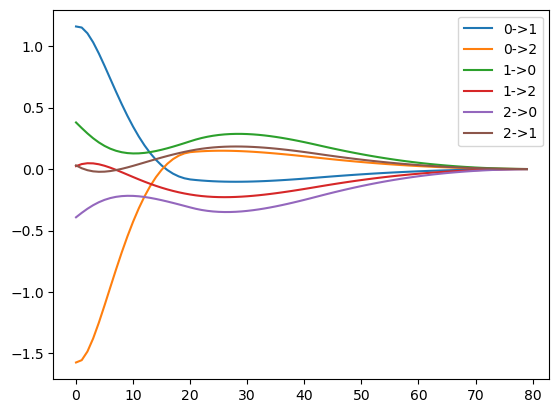

In [599]:
# for iarea in range(narea-1):
#     plt.plot(model.coupling_filters[iarea][iarea+1][:,:,0].mean(axis=0).detach().numpy().T)

for iarea in range(narea):
    for jarea in range(narea):
        if iarea==jarea:
            continue
        plt.plot(model.coupling_filters[iarea][jarea][:,:,0].mean(axis=0).detach().numpy().T, label=f'{iarea}->{jarea}')
plt.legend()